# Example 1:

This example is based on the following paper: Silva and Stojadinovic (2024). Behavior prediction equations for sliding base-isolated structures.

Goals of the example:

(1) Use the PCE_calculator$^{*1}$ module to calculate the cloud coefficients ($c_1$, $c_2$, $\beta_{GM}$) for a specific set of input parameters ($T_1 = 0.5s$, $m_1^* / m_{tot} = 0.8$, $\mu_f = 0.05$, and $T_b = 4s$).

(2) Given the cloud parameters calculate the fragility curve$^{*2}$ for the limit state thresholds $D_{1,lim} = 0.05m$ and $u_{0,lim} = 0.2m$

$^{*1}:$ The explanation of how the PCE metamodels are calculated is available in the paper (Silva and Stojadinovic, 2024).

$^{*2}:$The relationship between the cloud coefficients and the fragility curve is available in the paper (Silva and Stojadinovic, 2024).

In [1]:
from PCE_calculator import InputChecker
from PCE_calculator import DataLoader
from PCE_calculator import PCECalculator

# Input
T1 = 0.5 # possible from 0.1 to 1
mratio = 0.8 # possible from 0.3 to 0.9
muf = 0.05 # possible from 0.03 to 0.18
Tb = 4 # possible from 3 to 6

# Type of Analysis
RQI = 'D1' # Response quantity of interest: possible entries 'D1' or 'u0'
IM = 'GM' # Intensity Measure: possible entries 'SC' for single component and 'GM' for geometric mean

# Calculate PCE
c1D1, c2D1, betaD1 = PCECalculator.run_PCE(T1,muf,mratio,Tb,RQI,IM)

# Type of Analysis
RQI = 'u0' # Response quantity of interest: possible entries 'D1' or 'u0'
IM = 'GM' # Intensity Measure: possible entries 'SC' for single component and 'GM' for geometric mean

# Calculate PCE
c1u0, c2u0, betau0 = PCECalculator.run_PCE(T1,muf,mratio,Tb,RQI,IM)

print(f'PCE coefficients for D1 (for the Geometric Mean of Sd(T1)): c1= {c1D1}, c2= {c2D1}, beta = {betaD1} ')
print(f'PCE coefficients for u0 (for the Geometric Mean of PGV): c1= {c1u0}, c2= {c2u0}, beta = {betau0} ')

PCE coefficients for D1 (for the Geometric Mean of Sd(T1)): c1= -3.595309145999489, c2= 0.35695078982221917, beta = 0.24527455921217708 
PCE coefficients for u0 (for the Geometric Mean of PGV): c1= -1.0443769970277221, c2= 1.4644204358811015, beta = 0.5014926223014843 


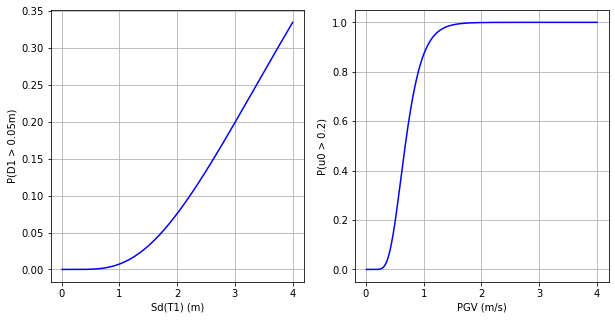

In [2]:
import numpy as np
from scipy.stats import norm
def frag_from_coefs(limit, IMs, c1, c2, beta):
    """
    Calculate the fragility function based on the cloud coefficients c1, c2 and beta.
    The fragility function is the probability of exceeding a "limit" given a "Sd".
    The formula of the cloud analysis is: ln(displacement) = c1 + c2 * ln(IM) + beta

    Args:
    - limit: limit threshold.
    - c1, c2, beta = cloud coefficients
    - IMs: Vector of intensity measure values (herein, Sd(T1) and PGV).

    Returns:
    - fragility: Vector of the fragility curve given IMs.
    """
    # Calculate the argument of the CDF
    argument = (np.log(limit) - (c1 + c2 * np.log(IMs))) / beta

    # Calculate the CDF using scipy.stats.norm.cdf
    fragility = 1 - norm.cdf(argument, 0, 1)

    return fragility

# Threshold limit for fragility function:
frag_limD1 = 0.05 # in meters
frag_limu0 = 0.2 # in meters

# Vector of IMs for the fragility function:
IMs = np.linspace(0.01, 4, num=400)
# Calculate fragility
fragilityD1 = frag_from_coefs(frag_limD1, IMs, c1D1, c2D1, betaD1)
fragilityu0 = frag_from_coefs(frag_limu0, IMs, c1u0, c2u0, betau0)

import matplotlib.pyplot as plt
fig, SubFig = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
SubFig[0].plot(IMs, fragilityD1, color='b', linestyle='-')
SubFig[0].set_xlabel('Sd(T1) (m)')
SubFig[0].set_ylabel('P(D1 > 0.05m)')
SubFig[0].grid(True)

SubFig[1].plot(IMs, fragilityu0, color='b', linestyle='-')
SubFig[1].set_xlabel('PGV (m/s)')
SubFig[1].set_ylabel('P(u0 > 0.2)')
SubFig[1].grid(True)